In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
import mplhep as hep
plt.style.use(hep.style.ROOT)

from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras 
#import setGPU
from numpy.random import seed
import tensorflow as tf
from model import model_ConvDNN, model_DNN
from keras import regularizers, Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import mean_absolute_error, MeanAbsoluteError, mean_squared_error, MeanSquaredError

2022-02-10 12:43:20.653495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 12:43:20.653535: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model_outdir = 'CNN_v1_totalcharge_nolocation'
model_name = 'best_model_DNN'
model_type = 'DNN' 

In [3]:
test_truth = pd.read_hdf('../Preprocessing/truths_0-48k.h5').to_numpy()[40000:48000,3]
test_pred = np.squeeze(np.load('{}/prediction_test_40-48k.npy'.format(model_outdir)))

#Sum of all tcs
test_sum_dummy = pd.read_hdf('train_40-48k.h5').to_numpy()
test_sum_pred = test_sum_dummy.reshape(8000, 800, 6)[:,:, -1].sum(axis=1)/16

e_residual_ai = test_truth - test_pred
e_residual_sum = test_truth - test_sum_pred

In [4]:
#### DIVIDE INTO DIFFERENT ENERGY RANGES
def fit_resolution_model(emin, emax, emean, e_residual):
    
    E = 1000
    
    #plt.hist(e_residual, density = True, bins = 100, range = (-E, E))

    #Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(-E, E, 101)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

    mask = data_entries!=0

    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                        sigma = np.sqrt(data_entries[mask]),
                        absolute_sigma = False, p0=[0.01, 0, 200])

    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    res_fit = std_fit/mean_fit
    sigma_res = perr[2]/mean_fit
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    print("Resolution (fit) is {}".format(res_fit))

    #Plot fitted gaussian
#     plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
#     plt.title("Energy range ({},{}) GeV".format(emin,emax))
#     plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
#     plt.legend()
#     plt.show()

    return std_fit/emean, perr[2]/emean

def plot_res_with_E_model(e_residual_all, truth_e):
    
    #Data points for plotting
    E_range = []
    E_res = []
    E_err = []
    E_average = []
    
    #Loop through different energy ranges
    for i in range(0,10):
        
        emin = i*150
        emax = (i+1)*150
        
        E_range.append([emin,emax])
        
        print("Energy range: ", (emin,emax))
        
        e_residual = e_residual_all[(truth_e > emin) & (truth_e <= emax)]
        
        emean = np.mean(truth_e[(truth_e > emin) & (truth_e <= emax)])
        E_average.append(emean)
        
        res, err = fit_resolution_model(emin, emax, emean, e_residual)
        
        E_res.append(res)
        E_err.append(err)
        
    ###### Plot resolution versus energy
    #Plot momentum average
    plt.scatter(E_average, E_res, s=180, c='#2ca02c', label = "E mean [GeV]", zorder = 10)
    
    plt.hlines(E_res,
               [x[0] for x in E_range],
               [x[1] for x in E_range],
               colors='r', lw=5,
               label = 'E resolution (model)',
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in E_range],
                E_res,
                yerr=E_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    
    plt.xlabel(r'Truth E [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~E}/E_{mean}$ [GeV]')
    
    plt.legend()
#     plt.show()
    
    #print(E_res)
    print(E_err)
    
    return

In [5]:
#### DIVIDE INTO DIFFERENT ENERGY RANGES
def fit_resolution_sum(emin, emax, emean, e_residual):
    
    E = 500
    
    #plt.hist(e_residual, density = True, bins = 100, range = (-E, E))

    #Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(-E, E, 101)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

    mask = data_entries!=0

    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                        sigma = np.sqrt(data_entries[mask]),
                        absolute_sigma = False, p0=[0.01, 0, 200])

    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    res_fit = std_fit/mean_fit
    sigma_res = perr[2]/mean_fit
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    print("Resolution (fit) is {}".format(res_fit))

    #Plot fitted gaussian
#     plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
#     plt.title("Energy range ({},{}) GeV".format(emin,emax))
#     plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
#     plt.legend()

    return std_fit/emean, perr[2]/emean

def plot_res_with_E_sum(e_residual_all, truth_e):
    
    #Data points for plotting
    E_range = []
    E_res = []
    E_err = []
    E_average = []
    
    #Loop through different energy ranges
    for i in range(0,10):
        
        emin = i*150
        emax = (i+1)*150
        
        E_range.append([emin,emax])
        
        print("Energy range: ", (emin,emax))
        
        e_residual = e_residual_all[(truth_e > emin) & (truth_e <= emax)]
        
        emean = np.mean(truth_e[(truth_e > emin) & (truth_e <= emax)])
        E_average.append(emean)
        
        res, err = fit_resolution_sum(emin, emax, emean, e_residual)
        
        E_res.append(res)
        E_err.append(err)
        
    ###### Plot resolution versus energy
    #Plot momentum average
    plt.scatter(E_average, E_res, s=180, c='#2ca02c', zorder = 10)
    
    plt.hlines(E_res,
               [x[0] for x in E_range],
               [x[1] for x in E_range],
               colors='y', lw=5,
               label = 'E resolution (sum)',
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in E_range],
                E_res,
                yerr=E_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    
    plt.xlabel(r'Truth E [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~E}/E_{mean}$ [GeV]')
    
    plt.legend()
    
    print(E_res)
    print(E_err)
    
    return

Energy range:  (0, 150)
[0.00111459 0.30104744 0.22305296]
Standard deviation (fit) is 11.601032872807096
Mean (fit) is 3.809956695420422
Resolution (fit) is 3.044925126511692
Energy range:  (150, 300)
[0.00138822 0.59234106 0.44648818]
Standard deviation (fit) is 14.564562550520877
Mean (fit) is 3.6890055654780047
Resolution (fit) is 3.9480999125664553
Energy range:  (300, 450)
[0.00127103 1.02703325 0.77640803]
Standard deviation (fit) is 19.84100701234158
Mean (fit) is 2.135376361767793
Resolution (fit) is 9.29157377948869
Energy range:  (450, 600)
[1.11087911e-03 1.48854057e+00 1.10198928e+00]
Standard deviation (fit) is 25.28765453453313
Mean (fit) is 0.26864055377185075
Resolution (fit) is 94.13193272378845
Energy range:  (600, 750)
[6.59560148e-04 1.50767549e+00 1.13218983e+00]
Standard deviation (fit) is 33.23049485442356
Mean (fit) is 1.798123431490772
Resolution (fit) is 18.48065281418035
Energy range:  (750, 900)
[5.06818102e-04 1.99464331e+00 1.43176807e+00]
Standard deviat

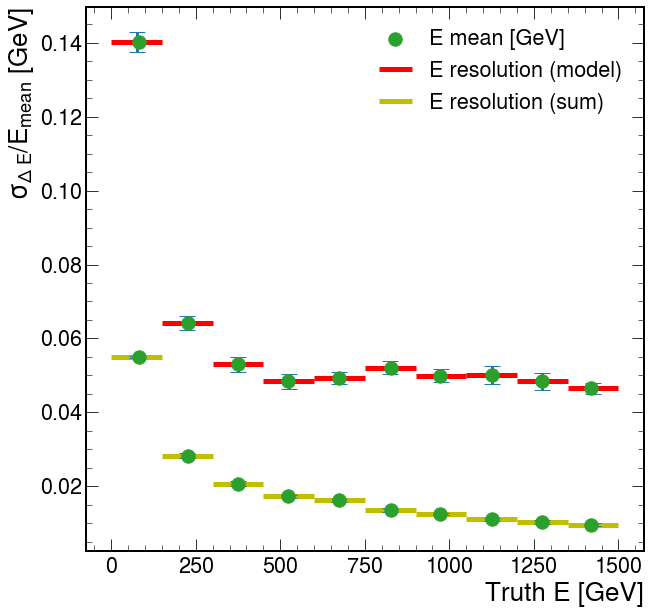

In [6]:
plot_res_with_E_model(e_residual_ai, test_truth)
plot_res_with_E_sum(e_residual_sum, test_truth)
plt.show()